<a href="https://colab.research.google.com/github/danshaub/Spectography/blob/main/Music_Spec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

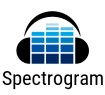
---
Analysis of music genre recognition & affective music classification
---
*Robert Farmer, Charles Filce, Dan Haub*


In [1]:
#### Check GPU availability ####
#!pip install gputil
#!pip install psutil
#!pip install humanize

# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))
    
# Execute function
mem_report()

ModuleNotFoundError: ignored

In [43]:
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import gzip

from scipy import signal
from scipy.fft import fftshift

# Get file object for spectrogram data. 
# Takes label and file name as params
def getFile(label,name):
  file = r'https://github.com/danshaub/Spectography/blob/main/data/fma_genre_spectrograms/'
  file += label + '/' + name + '?raw=true'
  return(urllib.request.urlopen(file))

# Get an ndarray of spectrogram data.
# Takes either a file name, file object, or a tuple in the form (lable, fileName) anr 
def openSpec(fileName=None, fileObj=None, attr=None):
  if attr:
    fileObj = getFile(attr[0],attr[1])
  with gzip.GzipFile(filename=fileName, fileobj=fileObj, mode='r') as f:
    return np.flip(np.load(f)[:128], 0)

# Displays spectrogram for a given song
# Takes an ndarray of spectrogram data and a compression value
# Compresses image by a factor of 2^compression
def viewSpec(spec, compression=3):
  plt.figure(figsize = (spec.shape[1]/(2**compression), spec.shape[0]/(2**compression)))
  plt.imshow(spec, interpolation='nearest', aspect='auto')
  plt.set_cmap('cool')
  plt.axis('off')
  plt.show()

def splitSpec(spec):
  frames = []
  for i in range(0, spec.shape[1], 256):
    frame = spec[:,i:i+256]
    if frame.shape[1] == 256:
      frames.append(frame)
  return frames


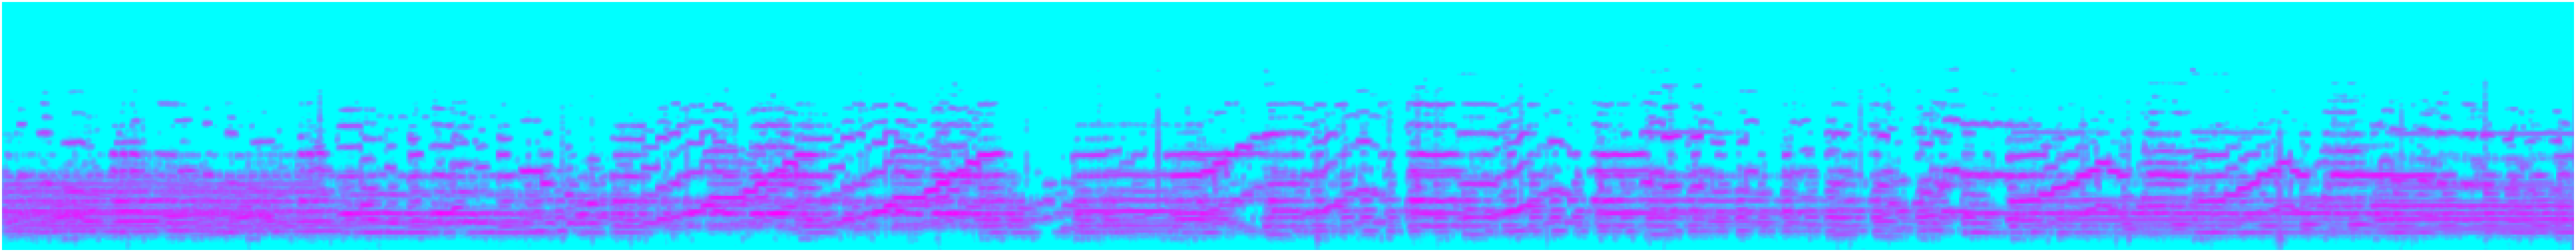

In [32]:
spec = openSpec(attr=('Classical', '41410.fused.full.npy.gz'))
viewSpec(spec)

In [4]:
import pandas as pd

fullUrl = "https://raw.githubusercontent.com/danshaub/Spectography/main/data/full_set.csv"
trainUrl = "https://raw.githubusercontent.com/danshaub/Spectography/main/data/train_set.csv"
testUrl = "https://raw.githubusercontent.com/danshaub/Spectography/main/data/test_set.csv"

full = pd.read_csv(fullUrl)
train = pd.read_csv(trainUrl)
test = pd.read_csv(testUrl)

In [8]:
full.head()

,Label,FileName
0,Blues,1042.fused.full.npy.gz
1,Blues,1043.fused.full.npy.gz
2,Blues,1044.fused.full.npy.gz
3,Blues,1045.fused.full.npy.gz
4,Blues,1046.fused.full.npy.gz


In [9]:
train.head()

,Label,FileName
0,Blues,43458.fused.full.npy.gz
1,Blues,21307.fused.full.npy.gz
2,Blues,4537.fused.full.npy.gz
3,Blues,3433.fused.full.npy.gz
4,Blues,20578.fused.full.npy.gz


In [10]:
test.head()

,Label,FileName
0,Blues,3841.fused.full.npy.gz
1,Blues,12790.fused.full.npy.gz
2,Blues,16024.fused.full.npy.gz
3,Blues,25109.fused.full.npy.gz
4,Blues,123949.fused.full.npy.gz


Label                          Jazz
FileName    33152.fused.full.npy.gz
Name: 1707, dtype: object


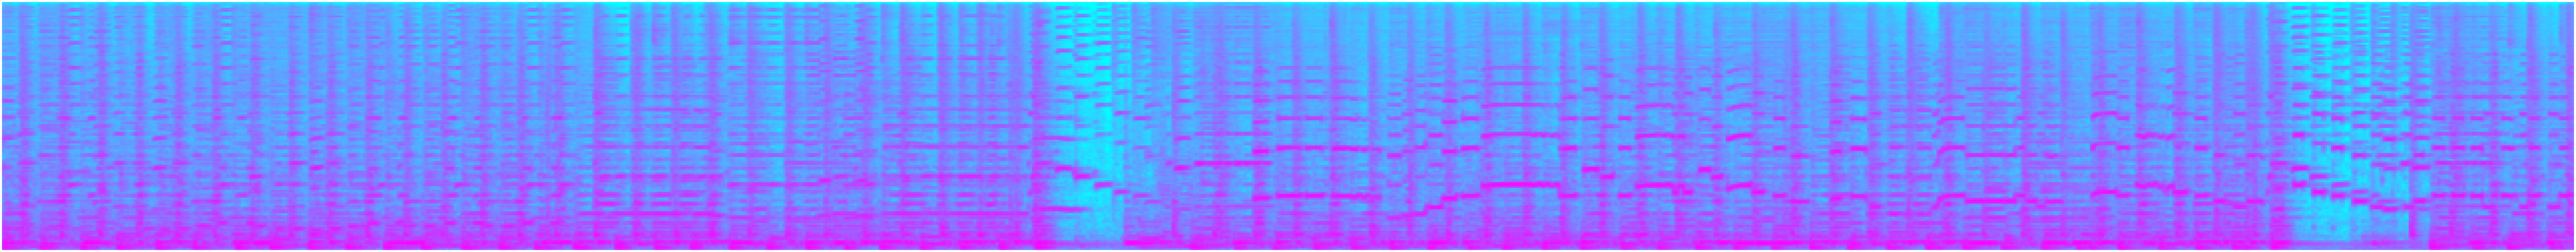

In [36]:
import random

indx = random.randint(0, len(full)-1)
row = full.iloc[indx]

print(row)

# This is how the data from the dataset is accessed
spec = openSpec(attr=(row['Label'],row['FileName']))
viewSpec(spec)

In [44]:
sps = splitSpec(spec)
for sp in sps:
  print(sp.shape)

(128, 256)
(128, 256)
(128, 256)
(128, 256)
(128, 256)
